In [1]:
%matplotlib inline

In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import KNNWithMeans
from surprise import Dataset,Reader
from surprise import accuracy
from surprise.model_selection import train_test_split,cross_validate,GridSearchCV
from collections import defaultdict
from surprise import SVD
from surprise import NormalPredictor,BaselineOnly,KNNBasic,KNNWithZScore,KNNBaseline, SVDpp,NMF,SlopeOne,CoClustering

In [3]:
# Loading the dataset
df = pd.read_csv('ratings_Electronics.csv')

In [4]:
# checking the dataset
df.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [5]:
# Adding the column names
df = pd.read_csv('ratings_Electronics.csv', names = ['UserId','ProductId','Rating','TimeStamp'])

In [6]:
# checking the dataset again
df.head()

,UserId,ProductId,Rating,TimeStamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [7]:
# checking the shape of the dataset
df.shape

(7824482, 4)

#### There are 78,24,481 rows. There are 4 attributes.

In [8]:
df.dtypes

UserId        object
ProductId     object
Rating       float64
TimeStamp      int64
dtype: object

UserID and Product ID are object data types. Rating is of datatype float and Time Stamp is of data type integer

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
UserId       object
ProductId    object
Rating       float64
TimeStamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [10]:
df.isna().apply(pd.value_counts)

,UserId,ProductId,Rating,TimeStamp
False,7824482,7824482,7824482,7824482


There are no null values in the dataset.

## EDA

#### Ratings distribution

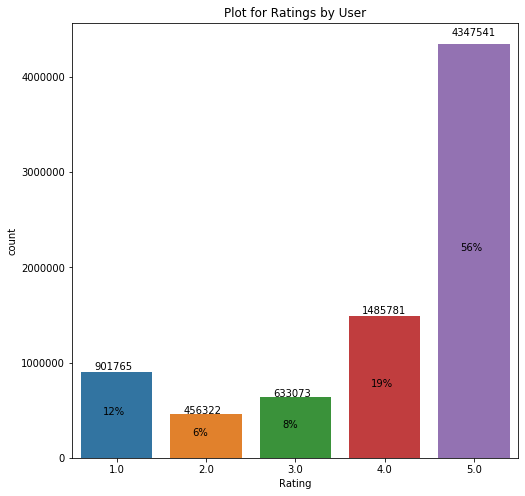

In [11]:
plt.figure(figsize=(8,8))
plt.title("Plot for Ratings by User")
ax = sns.countplot(df['Rating'])
for p in ax.patches:
    ax.annotate('{:1d}'.format(p.get_height()),(p.get_x()+0.15,p.get_height()*1.02))
    ax.annotate('{:.0f}%'.format((p.get_height()/len(df.index))*100),(p.get_x()+0.25,p.get_height()/2))

- The ratings ranges from 1 to 5.
- Out of the total ratings,
- 56% of the ratings is 5.0
- 19% of the ratings is 4.0
- 12% of the ratings is 1.0
- 8% of the ratings is 3.0
- 6% of the ratings is 2.0

#### Rating distribution by Product

(array([251918.,  66301.,  32698.,  20169.,  14019.,  10446.,   8199.,
          6592.,   5474.,   4622.,   3941.,   3449.,   3097.,   2644.,
          2351.,   2062.,   1869.,   1716.,   1631.,   1361.,   1290.,
          1309.,   1093.,   1024.,    969.,    866.,    878.,    811.,
           768.,    769.,    669.,    621.,    599.,    559.,    500.,
           522.,    469.,    468.,    401.,    419.,    411.,    404.,
           371.,    333.,    331.,    377.,    292.,    300.,    275.,
         13345.]),
 array([  1.  ,   2.98,   4.96,   6.94,   8.92,  10.9 ,  12.88,  14.86,
         16.84,  18.82,  20.8 ,  22.78,  24.76,  26.74,  28.72,  30.7 ,
         32.68,  34.66,  36.64,  38.62,  40.6 ,  42.58,  44.56,  46.54,
         48.52,  50.5 ,  52.48,  54.46,  56.44,  58.42,  60.4 ,  62.38,
         64.36,  66.34,  68.32,  70.3 ,  72.28,  74.26,  76.24,  78.22,
         80.2 ,  82.18,  84.16,  86.14,  88.12,  90.1 ,  92.08,  94.06,
         96.04,  98.02, 100.  ]),
 <a list of 50 Pat

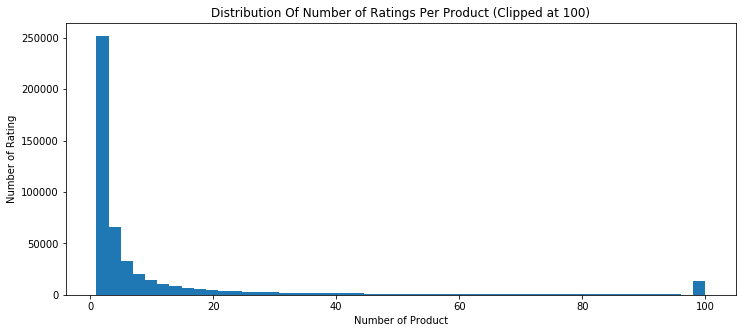

In [12]:
# Number of ratings per product
data = df.groupby('ProductId')['Rating'].count().clip(upper = 100)
plt.figure(figsize=(12,5))
plt.title("Distribution Of Number of Ratings Per Product (Clipped at 100)")
plt.xlabel("Number of Product")
plt.ylabel("Number of Rating")
plt.hist(data,bins=50)

The distribution of ratings is highly skewed with every user rating only 1 or 2 products.

Rating distribution by User

(array([3.815326e+06, 2.077010e+05, 9.994500e+04, 2.731100e+04,
        2.117800e+04, 7.841000e+03, 7.322000e+03, 3.061000e+03,
        3.216000e+03, 1.472000e+03, 1.184000e+03, 1.284000e+03,
        6.830000e+02, 8.220000e+02, 3.890000e+02, 4.420000e+02,
        2.700000e+02, 3.420000e+02, 2.020000e+02, 1.705000e+03]),
 array([ 1.  ,  3.45,  5.9 ,  8.35, 10.8 , 13.25, 15.7 , 18.15, 20.6 ,
        23.05, 25.5 , 27.95, 30.4 , 32.85, 35.3 , 37.75, 40.2 , 42.65,
        45.1 , 47.55, 50.  ]),
 <a list of 20 Patch objects>)

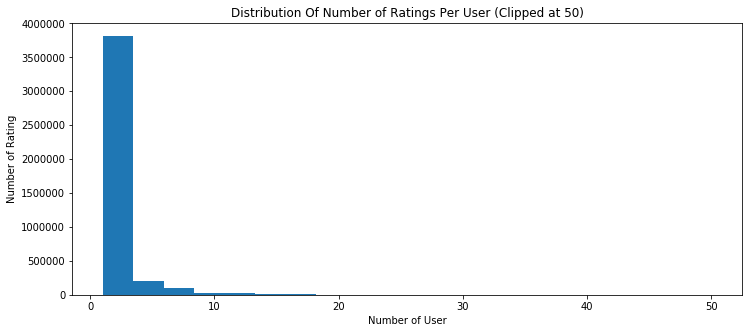

In [13]:
# Number of ratings per user
data = df.groupby('UserId')['Rating'].count().clip(upper = 50)
plt.figure(figsize=(12,5))
plt.title("Distribution Of Number of Ratings Per User (Clipped at 50)")
plt.xlabel("Number of User")
plt.ylabel("Number of Rating")
plt.hist(data,bins=20)

The distribution of number of ratings given by user is also highly skewed.

In [14]:
print("Total number of Ratings",df.shape[0])
print("Total number of Users", len(np.unique(df['UserId'])))
print("Total number of Products", len(np.unique(df['ProductId'])))

Total number of Ratings 7824482
Total number of Users 4201696
Total number of Products 476002


In [15]:
# analysing the ratings given by each user
no_of_produts_rated_by_each_user = df.groupby('UserId')['Rating'].count()
no_of_produts_rated_by_each_user.describe()

count    4.201696e+06
mean     1.862220e+00
std      2.885110e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      5.200000e+02
Name: Rating, dtype: float64

- A single user has rated 1 product to maximum of 520 products
- 75% of users have rated only 2 products and 50% of users have rated only 1 product
- The mean value is 1.86 and median is 1

In [16]:
array = np.array(no_of_produts_rated_by_each_user)

In [17]:
count=[]
index = []
val = np.unique(array)
for i in val:
    u = no_of_produts_rated_by_each_user==i
    c = u[u].count()
    count.append(c)
    index.append(i)
final_count = pd.DataFrame({'No of products rated':index,'Number of customers':count})

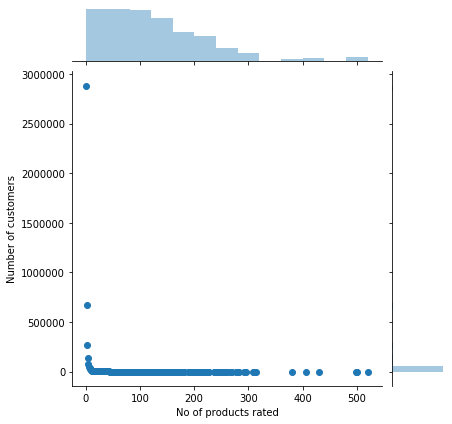

In [18]:
sns.jointplot(final_count['No of products rated'],final_count['Number of customers'],kind='scatter')

In [19]:
final_count[final_count['No of products rated']>=50].sum()

No of products rated    25810
Number of customers      1540
dtype: int64

- Out of 4,76,002 products, 25,810 products has been rated by more than 50 customers
- Out of 4,20,1696 users, 1540 users have rated these 25,810 products

In [20]:
# The Time Stamp column doesnt contribute to our recommendation and hence can be dropped
df.drop('TimeStamp',axis=1,inplace=True)

In [21]:
# checking the data
df.head()

,UserId,ProductId,Rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


## Popularity Based Recommendation

In [22]:
ratings_mean_count = pd.DataFrame(data = df.groupby('ProductId')['Rating'].mean())

In [23]:
ratings_mean_count

,Rating
ProductId,
0132793040,5.000000
0321732944,5.000000
0439886341,1.666667
0511189877,4.500000
0528881469,2.851852
...,...
BT008G3W52,5.000000
BT008SXQ4C,1.000000
BT008T2BGK,5.000000


In [24]:
ratings_mean_count.head()

,Rating
ProductId,
0132793040,5.000000
0321732944,5.000000
0439886341,1.666667
0511189877,4.500000
0528881469,2.851852


#Lets also find out how many users have given these ratings to recommend using popularity based recommendation method.

In [25]:
ratings_mean_count['rating_count']=pd.DataFrame(df.groupby('ProductId')['Rating'].count())

In [26]:
ratings_mean_count.shape

(476002, 2)

In [27]:
ratings_mean_count.sort_values('rating_count',ascending=False).head()

,Rating,rating_count
ProductId,,
B0074BW614,4.491504,18244
B00DR0PDNE,3.931020,16454
B007WTAJTO,4.424005,14172
B0019EHU8G,4.754497,12285
B006GWO5WK,4.314657,12226


- The popularity based recommendation is used when a new user visits the site and we don't have the shopping history. The most popular products i.e., the most rated and the higest rated products are displayed.

## Collaborative Filtering

To reduce the dimensionality of the data set, and avoid running into “memory error”, we will filter out rarely rated products and rarely rating users.

In [28]:
min_product_ratings = 50
filter_products = df['ProductId'].value_counts() >= min_product_ratings
filter_products = filter_products[filter_products].index.tolist()

min_user_ratings = 50
filter_users = df['UserId'].value_counts() >= min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df1 = df[(df['UserId'].isin(filter_users))]
df_new = df1[(df1['ProductId'].isin(filter_products))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(7824482, 3)
The new data frame shape:	(79182, 3)


In [29]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_new,reader)

### With the Surprise library, we will benchmark the following algorithms:
#### Basic algorithms
##### NormalPredictor
###### NormalPredictor algorithm predicts a random rating based on the distribution of the training set, which is assumed to be normal.This is one of the most basic algorithms.
##### BaselineOnly
###### BaselineOnly algorithm predicts the baseline estimate for given user and item.
#### k-NN algorithms
##### KNNBasic
###### KNNBasic is a basic collaborative filtering algorithm.
##### KNNWithMeans
###### KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user.
##### KNNWithZScore
###### KNNWithZScore is a basic collaborative filtering algorithm, taking into account the z-score normalization of each user.
##### KNNBaseline
###### KNNBaseline is a basic collaborative filtering algorithm taking into account a baseline rating.
#### Matrix Factorization-based algorithms
##### SVD
###### SVD algorithm is equivalent to Probabilistic Matrix Factorization
##### SVDpp
###### The SVDpp algorithm is an extension of SVD that takes into account implicit ratings.
##### NMF
###### NMF is a collaborative filtering algorithm based on Non-negative Matrix Factorization. It is very similar with SVD.
##### Slope One
###### SlopeOne is a straightforward implementation of the SlopeOne algorithm.
##### Co-clustering
###### Coclustering is a collaborative filtering algorithm based on co-clustering.

In [30]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,0.957058,0.119765,0.114555
SVD,0.960049,2.431733,0.156204
SVDpp,0.963104,26.082387,1.041417
KNNBaseline,1.041565,0.380115,0.593611
KNNWithMeans,1.046360,0.145783,0.489478
KNNWithZScore,1.051046,0.260396,0.536321
CoClustering,1.062926,2.020364,0.104142
SlopeOne,1.083793,43.830952,35.642613
KNNBasic,1.106448,0.098943,0.447809


## Collaborative Filtering - user-user filtering

In [31]:
trainset, testset = train_test_split(data,test_size=0.3)

In [32]:
algo = KNNWithMeans(k=50,sim_options={'name':'pearson_baseline','user_based': True})

In [33]:
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [34]:
# run the trained model against the testset
test_pred = algo.test(testset)

In [35]:
# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

User-based Model : Test Set
RMSE: 1.0303


1.0303379810686955

## Collaborative Filtering - item-item filtering

In [36]:
algo = KNNWithMeans(k=50,sim_options={'name':'pearson_baseline','user_based': False})

In [37]:
algo.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [38]:
# run the trained model against the testset
test_pred1 = algo.test(testset)

In [39]:
# get RMSE
print("Item-based Model : Test Set")
accuracy.rmse(test_pred1, verbose=True)

Item-based Model : Test Set
RMSE: 1.1257


1.1256694997594472

Based on the RMSE values, SVD seems to better fit the problem

## Parameter optimisation using GridSearchCV

In [40]:
param_grid = {'n_epochs': [5, 10, 15], 'lr_all': [0.002, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

In [41]:
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

In [42]:
# best RMSE score
print(gs.best_score['rmse'])

0.9561267616302779


In [43]:
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

{'n_epochs': 15, 'lr_all': 0.01, 'reg_all': 0.2}


# Let's train SVD with parameters obtained

In [44]:
algo = SVD(n_epochs = 15, lr_all = 0.01, reg_all = 0.2)
algo.fit(trainset)

In [45]:
predictions = algo.test(testset)

In [46]:
# get RMSE
print("SVD : Test Set")
accuracy.rmse(predictions, verbose=True)

SVD : Test Set
RMSE: 0.9479


0.9478571939869888

In [47]:
def get_top_n(predictions, n=5):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

Get top -K ( K = 5) recommendations

In [48]:
top_n = get_top_n(predictions, n=5)

In [49]:
# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

A680RUE1FDO8B ['B005LDLP8W', 'B0011Z44UA', 'B005HY4U46', 'B00BOHNYTW', 'B0015L0T68']
A1VFX417XDNWIU ['B00D5Q75RC', 'B00E40QPX8', 'B000AY5Y5W', 'B00ATM1MGA', 'B00BD7UXT2']
A6VPK7X53QNAQ ['B00FJWKYYG', 'B002HWRJY4', 'B000LRMS66', 'B000N8OFIW', 'B00HRQB28Y']
A3L9E0YI7C5G0W ['B00DK2JQOQ', 'B0002KVQBA', 'B0011ZK6PC', 'B0081ER9KG', 'B004EBX5GW']
ATDE9JYCPI0L1 ['B00029U1DK', 'B0034CL2ZI', 'B00004SB92', 'B003NR57BY', 'B0007YFQH6']
A2MJ8OL2FYN7CW ['B000CKVOOY', 'B004GYVPGE', 'B006DDT6JO', 'B006MVX5B2', 'B0007XDI54']
A27B1U3OWCU14J ['B002TLTE6O', 'B003IHUHGE', 'B000WAHFBK', 'B000FBK3QK', 'B001BY97JO']
AOWF9T81XMX2S ['B003ES5ZUU', 'B003MQWN40', 'B000WXAX6G', 'B00DIFIM36', 'B00E9QK2MW']
A1YE1IK0JYSIIE ['B001TH7GUU', 'B009AETXPK', 'B00DI4CZJ4', 'B005JV06QI', 'B00EB7812C']
ADZF3QDGSZE7K ['B0000BZL1P', 'B001TH7GSW', 'B00D6XW62I', 'B00139W0XM', 'B001TANZ0W']
A1EH2S92FHWZRP ['B0012Y2LLE', 'B0017JY5FE', 'B000M2GYF6', 'B000PO3CTM', 'B004BLIQDC']
A35Q0RBM3YNQNF ['B009UNZ5WQ', 'B00310PJM0', 'B004CLYE8C', '

After analysing the Popularity based recommender and various collaborative filtering, SVD with optimised parameters gives the least RMSE of 0.948. Hence it is used to give top 5 recommendations for each user